**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras alamancenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
# for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py
from general import configure_lab2
configure_lab2()
from lab2 import *
GRADER, x, y = part_1()

--2021-10-06 04:28:05--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14633 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  14.29K  --.-KB/s    in 0s      

2021-10-06 04:28:05 (89.0 MB/s) - ‘general.py’ saved [14633/14633]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 2 - Parte 1. KNN para un problema de clasificación

### Ejercicio 1: Contextualización del problema


Usaremos el dataset iris para el problema de clasificación. En el UCI Machine Learning Repository se encuentra más información en el siguiente [link](https://archive.ics.uci.edu/ml/datasets/iris) .

In [29]:
print("muestra de los 5 primeros renglones de x:\n", x[0:5, :])
print("muestra de los 5 primeros renglones de y:\n", y[0:5])
print ("¿el resultado de esta instrucción que información nos brinda?", x.shape[0])
print ("¿el resultado de esta instrucción que información nos brinda?", x.shape[1])
print ("¿el resultado de esta instrucción que información nos brinda?", len(np.unique(y)))

muestra de los 5 primeros renglones de x:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
muestra de los 5 primeros renglones de y:
 [0 0 0 0 0]
¿el resultado de esta instrucción que información nos brinda? 150
¿el resultado de esta instrucción que información nos brinda? 4
¿el resultado de esta instrucción que información nos brinda? 3


En un problema de clasificación de más de una clase, tener un desbalance de muestras puede ser perjudicial para el proceso de entrenamiento. Vamos a crear una función para verificar el número de muestras por clases.

In [3]:
#Ejercicio de código
def muestras_por_clases (Y):
    """Funcion que calcula el número de muestras por cada clase
    Y: vector de numpy con las etiquetas de las muestras del conjunto X
    retorna: diccionario [int/float:int/float] 
        con la estructura:{etiquetaclase1: número de muestras clase1, etiquetaclase2: número de muestras clase2}
    """
    dicto = {}
    ## Pista se puede asginar keys a diccionario: dict[etiqueta] = valor
    for i in Y:
      if i in dicto.keys():
        dicto[i] = dicto[i] + 1
      else:
        dicto[i]= 1
    return (dicto)

In [4]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", muestras_por_clases)

TEST EXITOSO!


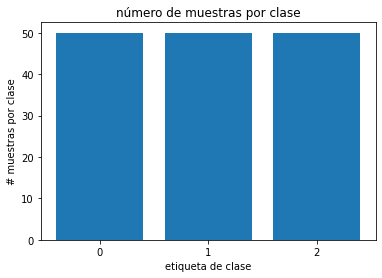

In [5]:
# con esta linea de codigo puedes ver la dsitribucion de forma grafica
fig, ax = plt.subplots()
ax.bar(muestras_por_clases(y).keys(), muestras_por_clases(y).values())
ax.set_title("número de muestras por clase")
ax.set_xlabel("etiqueta de clase")
ax.set_ylabel("# muestras por clase")
ax.set_xticks(list(muestras_por_clases(y).keys()))
plt.show()


In [6]:
#@title Pregunta Abierta
#@markdown  ¿dependiendo de los resultados de la informacion anterior, cuantas caracteristicas tiene el problema, muestras y como calficaria la distribución de clases?
respuesta_1 = "\"Hay un total de .......... caracteristicas, tiene un total de 150 muestra, habiendo 50 muestras por cada clase, la distribucion de clases se calificara como ideal ya que las clases se distribuyen de manera uniforme.\"" #@param {type:"string"}

### Ejercicio 2: Completar código KNN

Recordemos los conceptos vistos en teoria para los modelos basados en los K-vecimos más cercanos. En este ejercicio vamos a escribir la función que implementa este modelo. Pero primero vamos a definir la función que nos ayudara calcular el error de clasificación.

In [7]:
def ErrorClas(Y_lest, Y):
    """funcion que calcula el error de clasificación
    Y_lest: numpy array con la estimaciones de etiqueta
    Y: etiquetas reales
    retorna: error de clasificación (int)
    """
    error = 1 - np.sum(Y_lest == Y)/len(Y)
    
    return error


Ahora si es hora del ejercicio. Ten en cuenta lo siguiente:

<b>Pistas</b>

1. Para el cáculo de la distancia entre vectores existen varias opciones:
    1. usar la función la distancia entre matrices `scipy.spatial.distance.cdist`([Ejemplo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist))--esta puede ser usada directamente como `cdist(...)`. Entiende la salida de esta función. Al usarla, se logra un rendimiento superior.
    2. usar la función la distancia euclidiana `scipy.spatial.distance.euclidean`([Ejemplo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html))--pueder acceder a ella directamente como `euclidean`. Aca debe pensar en un algoritmo elemento a elemento, por lo tanto menos eficiente.
2. También serán de utilidad las funciones `np.sort` y `np.argsort`.
3. ten presente que la moda es una operación que calcula el valor más común. En el [notebook ya se encuentra cargada esta operacion](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html), es posible usarla de esta manera : `mode(y)`

In [8]:
#ejercicio de codigo
def KNN_Clasificacion(X_train, Y_train, X_test, k):
    """ Funcion que implementa el modelo de K-Vecino mas cercanos
        para clasificación
    X_train: es la matriz con las muestras de entrenamiento
    Y_train: es un vector con los valores de salida pra cada una de las muestras de entrenamiento
    X_test: es la matriz con las muestras de validación
    k (int): valor de vecinos a usar
    retorna: las estimaciones del modelo KNN para el conjunto X_test 
             esta matriz debe tener un shape de [row/muestras de X_test] 
             y las distancias de X_test respecto a X_train, estan matrix
             debe tener un shape de [rows de X_test, rows X_train]
             lo que es lo mismo [muestras de X_test, muestras de X_train]
    """
    if k > X_train.shape[0]:
        print("k no puede ser menor que las muestras de entrenamiento")
        return(None)
    Yest = np.zeros(X_test.shape[0])

    distancias = cdist(X_test,X_train)
    indices= np.argsort(distancias)
    indices=indices[:, :k]
    indices_2=np.take(Y_train, indices)
    enum= enumerate(indices_2)
    
    for i,array in enum:
      Yest[i] = mode(array)[0]
    
    return (Yest, distancias) 
  

In [9]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", KNN_Clasificacion)

TEST EXITOSO!


### Ejercicio 3: Experimentos de KNN

Ahora vamos a probar nuestro algoritmo. Pero antes de esto vamos a tener que dividir nuestro conjunto de datos, vamos a usar una función llamada train_test_split de la libreria sklearn. [Aca puedes ver la ayuda](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Entiende su funcionamiento. Vamos a usarla para crear una función con una propoción fija  de 70%-30% entre nuestro conjunto de entrenamiento y de pruebas.


In [10]:
#ejercicio de codigo
def train_test_split_fix(X,Y):
    """funcion que divide el conjunto de datos en
        entrenamiento y pruebas
        usando un proporcion fija de 30 %
        para el conjunto de pruebas.

    X: matriz de numpy con las muestras y caractersiticas
    Y: matriz de numpy con las las etiquetas reales
    retorna:
        Xtrain: conjunto de datos para entrenamiento
        Xtest: conjunto de datos para pruebas
        Ytrain: conjunto  de etiquetas para entrenamiento
        Ytest: conjunto de etiquetas para prueba 
    """
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.30)

    return (Xtrain, Xtest, Ytrain, Ytest)


In [11]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", train_test_split_fix)

TEST EXITOSO!


Vamos a proceder a experimentar. Para ello vamos a crear una función que realiza los experimentos usando las funciones previamente construidas. En el código se hace uso de la función [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), para normalizar los datos.

In [12]:
#Ejercicio de código
def experimentar (X, Y, ks):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas
    ks: List[int/float] lista con los valores de k-vecinos a usar
    retorna: dataframe con los resultados
    """

    # dividimos usando la función
    Xtrain, Xtest, Ytrain, Ytest = train_test_split_fix(X,Y)

    scaler = StandardScaler()
    scaler.fit(Xtrain)
    Xtrain= scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    resultados = pd.DataFrame()
    idx = 0
    for k in ks:
        # iteramos sobre la lista de k's
        resultados.loc[idx,'k-vecinos'] = k
        Yest, dist = KNN_Clasificacion(Xtrain, Ytrain, Xtest, k)
        errorTest = ErrorClas(Yest, Ytest)
        resultados.loc[idx,'error de prueba'] = errorTest
        idx+=1
    return (resultados)

In [13]:
#@title Pregunta Abierta
#@markdown como se observo en nuestros experimentos usamos una metodologia basica de dividir el conjunto de entrenamiento y pruebas. ¿Cual es la diferencia si quisieramos aplicar una metodologia de validación cruzada?
respuesta_2 = "\"La validacion cruzada se basa en tomar los datos originales y con estos crear dos conjuntos de datos diferentes, uno de entrenamiento (train) y uno de prueba (test), como se hizo en los ejercicios anteriores. La diferencia se encuentra en que la validacion cruzada divide el conjunto de entrenamiento en k subconjuntos y cada uno de estos se toma como conjunto de prueba, lo que equivale a muchas iteraciones para el calculo del error de cada modelo realizado.\"" #@param {type:"string"}

In [14]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio4", experimentar)

TEST EXITOSO!


Ahora ejecuta los experimentos con k = 2,3,4,5,6,7,10

In [15]:
resultados = experimentar (x, y,[2,3,4,5,6,7,10])
resultados

,k-vecinos,error de prueba
0,2.0,0.044444
1,3.0,0.044444
2,4.0,0.066667
3,5.0,0.066667
4,6.0,0.066667
5,7.0,0.066667
6,10.0,0.066667


### Ejercicio 4: ventana de Parzen

Ahora vamos a utilizar el metodo de ventana de parzen. Recuerde de las clases teoricas, quedemos usar una función kernel. En la siguiente celda se proponen dos funciones para:
1. calculo de un kernel gausiano
2. calculo de la ventana de parzen, es decir el termino: $ \sum_{i=1}^{N} K(u_i)$, siendo $\;\; u_i = \frac{d({\bf{x}}^*,{\bf{x}}_i)}{h}$ y la función $K$ el kernel gausiano

In [16]:
def kernel_gaussiano(x):
    """Calcula el kernel gaussiano de x
    x: matriz/vector de numpy
    retorna: el valor de de kernel gaussiano
    """
    return np.exp((-0.5)*x**2)

def ParzenWindow(x,Data,h):
    """"ventana de parzen
    x: vector con representando una sola muestra
    Data: vector de muestras de entrenamiento
    h: ancho de la ventana de kernel
    retorna: el valor de ventana de parzen para una muestra
    """
    h = h
    Ns = Data.shape[0]
    suma = 0
    for k in range(Ns):
        u = euclidean(x,Data[k,:])
        suma += kernel_gaussiano(u/h)
    return suma


Entiendalos la implementación de las anteriores funciones y uselas para resolver el ejercicio de código.

In [17]:
#Ejercicio de código

def clase_for_clase(X_train, Y_train, clase):
  a=[]
  i = 0
  while i < len(X_train):
    temp = X_train[i]
    if Y_train[i] == clase:
      a.append(temp)
    i = i + 1
  #sorted(set(_train).intersection(clase))
  return a
def parzenClass(X_train, Y_train, X_test, h):
    """ Funcion que implementa metodo de ventana de parzen para
        para clasificación
    X_train: es la matriz con las muestras de entrenamiento
    Y_train: es un vector con los valores de salida pra cada una de las muestras de entrenamiento
    X_test: es la matriz con las muestras de validación
    h (float): ancho de h de la ventana
    retorna: - las estimaciones del modelo parzen para el conjunto X_test 
              esta matriz debe tener un shape de [row/muestras de X_test]
             - las probabilidades de la vetana [row/muestras de X_test, número de clases]  
    """
        
    Yest = np.zeros(X_test.shape[0])
    clases = np.unique(Y_train)
    fds_matrix = np.zeros((X_test.shape[0], len(clases)))
    
    ## pista: recuerde el termino que acompaña al sumatoria (N)
    
    for n, sample in enumerate(X_test):
        for m,label in enumerate(clases):

          fds_matrix[n,m] = ParzenWindow(sample,np.array(clase_for_clase(X_train, Y_train, label)),h) /(muestras_por_clases(Y_train)[m])

        Yest[n] = fds_matrix[n,:].argmax()
    #Debe retornar un vector que contenga las predicciones para cada una de las muestras en X_val, en el mismo orden.  
    return Yest, fds_matrix

In [18]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio5", parzenClass)

TEST EXITOSO!


### Ejercicio 5 - Experimentos con Parzen

Ahora vamos a realizar los experimentos, pero esta vez, debemos implementar otro tipo de validación. Dentro del código se encuentra ya esta implementación sugerida, usando [esta función](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [19]:
#@title Pregunta Abierta
#@markdown ¿cual es la metodologia de validación usada en el experimento? ¿qué diferencia tiene respecto a una validación cruzada?
respuesta_3 = "\"La metodologia de validacion usada fue Validacion cruzada de K-pliegues estratificada, se diferencia con respecto a la validacion cruzada en el uso de pliegues que se definen conservando el porcentaje de muestras de cada clase. \"" #@param {type:"string"}

In [20]:
#ejercicio de codigo
def experimentarParzen (X, Y, hs):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas
    ks: List[int/float] lista con los valores de k-vecinos a usar
    retorna: dataframe con los resultados, debe contener las siguientes columnas:
        - el ancho de ventana, el error medio de prueba, la desviacion estandar del error
    """
    
    
    # se usa la función para implementar la estrategia de validación.
    skf = StratifiedKFold(n_splits=4)
    resultados = pd.DataFrame()
    idx = 0
    # iteramos sobre los valores de hs
    for h in hs:
        # lista para almacenar los errores de cada iteración
        # de la validación
        error_temp = []
        
        for train, test in skf.split(X, Y):

            Xtrain = X[train,:]
            Ytrain = Y[train]
            Xtest = X[test,:]
            Ytest = Y[test]
            #normalizamos los datos
            scaler = StandardScaler()
            scaler.fit(Xtrain)
            Xtrain = scaler.transform(Xtrain)
            Xtest = scaler.transform(Xtest)
            
            Yest, probabilidades = parzenClass(Xtrain, Ytrain, Xtest , h)
            errorTest = ErrorClas(Yest, Ytest)
            error_temp.append(errorTest)
    
        resultados.loc[idx,'ancho de ventana'] = h 
        resultados.loc[idx,'error de prueba(media)'] = np.mean(error_temp)
        resultados.loc[idx,'error de prueba(desviación estandar)'] = np.std(error_temp)
        idx+=1
    return (resultados)

In [21]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio6", experimentarParzen)

TEST EXITOSO!


In [22]:
hs = [0.05, 0.1, 0.5, 1, 2, 5, 10]
experimentos_parzen = experimentarParzen(x,y, hs)
experimentos_parzen

,ancho de ventana,error de prueba(media),error de prueba(desviación estandar)
0,0.05,0.059922,0.039773
1,0.10,0.059922,0.039773
2,0.50,0.053343,0.026683
3,1.00,0.099929,0.010944
4,2.00,0.126600,0.010775
5,5.00,0.133179,0.017648
6,10.00,0.133179,0.017648


In [23]:
#@title Pregunta Abierta
#@markdown ¿por qué usando una ventana de parzen, no hay necesidad de definir un número de vecinos cercanos? 
respuesta_4 = "\"El metodo de parzen comprende todas las muestras del conjunto de entrenamiento para realizar la prediccion. Lo que hace es asociarle un peso a las muestras de entrenamiento respecto a la distancia de la muestra que se estan evaluando.\"" #@param {type:"string"}

In [24]:
#@title Pregunta Abierta
#@markdown ¿De acuerdo al problema, cual de las dos metodologias de validación usadas en los experimentos es la más recomendada?
respuesta_5 = "..." #@param {type:"string"}

In [25]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia le archivo al formulario ¡buen trabajo!


In [26]:
#@title Integrantes
codigo_integrante_1 ='1000415078' #@param {type:"string"}
codigo_integrante_2 = '1035833769'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo del los profesores


In [27]:
GRADER.grade()

uso del docente
